### Heart Disease Prediction

This projects tries to predict the presence of a heart disease of a patient. The prepared dataset is from
[Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci). The original dataset can be found on
[UCI](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

Following features are included in the dataset:

- age
- sex (1 = man, 0 = woman)
- cp; chest pain type (4 values)
    - 0 = typical angina
    - 1 = atypical angina
    - 2 = non anginal pain
    - 3 = asymptomatic pain
- trestbps; resting blood pressure
- chol; serum cholestoral in mg/dl
- fbs; fasting blood sugar > 120 mg/dl
- restecg; resting electrocardiographic results (values 0,1,2)
    - 0 = restecg normal
    - 1 = restecg wave abnormality
    - 2 = restecg ventricular hypertrophy
- thalach; maximum heart rate achieved
- exang; exercise induced angina
- oldpeak = ST depression induced by exercise relative to rest
- slope; the slope of the peak exercise ST segment (values 0,1,2)
    - 0 = slope upsloping
    - 1 = slope flat
    - 2 = slope downsloping
- ca; number of major vessels (0-3) colored by flourosopy
- thal: (values 1,2,3)
    - 1 = normal
    - 2 = fixed defect
    - 3 = reversable defect

The target is 1 (heart disease) or 0 (no heart disease).

In [1]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.callbacks import EarlyStopping

#### Get the dataset and create dataframe

In [2]:
# Check out the data https://www.kaggle.com/ronitf/heart-disease-uci
dataset = pd.read_csv('heart.csv', sep=',')

dataset.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The next step is to analyze the dataset and clean the data. To achieve good results with neural network, the features
have to be in a range of 0 - 1.

In [3]:
# Prepare the data
def prepare_data(org_dataset):

    # use clearer column names
    clear_names_column = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
                          'serum_cholestoral', 'fasting_blood_sugar', 'resting_electrocardiographic_results',
                          'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', 'slope', 'major_vessels',
                          'thal', 'target']

    dataset = copy.deepcopy(org_dataset)

    # Insert cleaner names
    dataset.columns = clear_names_column

    # cleaning data
    # 'ca' (number of major vessels) is in the range from 0-3 -> there a datapoints with the value 4
    # 'thal' ranges from 1-3 (1 = normal; 2 = fixed defect; 3 = reversable defect) -> there aere datapoints with the value 0
    # We don't know what the correct data shall be so we delete the rows with this values
    dataset['major_vessels'] = dataset.major_vessels.apply(lambda s: np.NaN if s == 4 else s)
    dataset['thal'] = dataset.thal.apply(lambda s: np.NaN if s == 0 else s)

    dataset.dropna(axis=0, inplace=True)
    dataset.reset_index(drop=True, inplace=True)

    # min-max scaling for:
    # age
    # trestbps; resting_blood_pressure
    # chol; serum_cholestoral
    # thalach; maximum_heart_rate_achieved
    # oldpeak

    list_for_minmax_scaling = ['age', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved',
                               'oldpeak']

    scaler = MinMaxScaler()

    dataset_scaled = pd.DataFrame(scaler.fit_transform(dataset[list_for_minmax_scaling]),
                                  columns=list_for_minmax_scaling)

    dataset.drop(columns=list_for_minmax_scaling, inplace=True, axis=1)

    dataset = dataset.join(dataset_scaled)

    # dummy encoding for:
    # cp; chest_pain_type
    # restecg; resting_electrocardiographic_results
    # slope
    # ca; major_vessels
    # thal

    # Dummy encoding
    list_for_dummy_encoding = ['chest_pain_type', 'resting_electrocardiographic_results', 'slope', 'major_vessels',
                               'thal']

    dataset_finalized = pd.get_dummies(dataset, columns=list_for_dummy_encoding)

    # rename the dummy columns for easier later analysis
    dataset_finalized = dataset_finalized.rename(
        columns = {'chest_pain_type_0':'chest_pain_typical_angina',
                   'chest_pain_type_1':'chest_pain_atypical_angina',
                   'chest_pain_type_2':'chest_pain_non_anginal_pain',
                   'chest_pain_type_3':'chest_pain_asymptomatic',
                   'resting_electrocardiographic_results_0':'rest_ecg_normal',
                   'resting_electrocardiographic_results_1':'rest_ecg_wave_abnormality',
                   'resting_electrocardiographic_results_2':'rest_ecg_ventricular_hypertrophy',
                   'slope_0':'slope_upsloping',
                   'slope_1':'slope_flat',
                   'slope_2':'slope_downsloping',
                   'thal_1.0':'thal_normal',
                   'thal_2.0':'thal_fixed_defect',
                   'thal_3.0':'thal_reversable_defect',
                   })

    # no tranformation nedded for :
    # sex
    # fbs; fasting_blood_sugar
    # exang; exercise_induced_angina

    labels = dataset_finalized.pop("target")

    return dataset_finalized, labels

In [4]:
features, labels = prepare_data(dataset)

features.head()

,sex,fasting_blood_sugar,exercise_induced_angina,age,resting_blood_pressure,serum_cholestoral,maximum_heart_rate_achieved,oldpeak,chest_pain_typical_angina,chest_pain_atypical_angina,...,slope_upsloping,slope_flat,slope_downsloping,major_vessels_0.0,major_vessels_1.0,major_vessels_2.0,major_vessels_3.0,thal_normal,thal_fixed_defect,thal_reversable_defect
0,1,1,0,0.708333,0.481132,0.244292,0.603053,0.370968,0,0,...,1,0,0,1,0,0,0,1,0,0
1,1,0,0,0.166667,0.339623,0.283105,0.885496,0.564516,0,0,...,1,0,0,1,0,0,0,0,1,0
2,0,0,0,0.250000,0.339623,0.178082,0.770992,0.225806,0,1,...,0,0,1,1,0,0,0,0,1,0
3,1,0,0,0.562500,0.245283,0.251142,0.816794,0.129032,0,1,...,0,0,1,1,0,0,0,0,1,0
4,0,0,1,0.583333,0.245283,0.520548,0.702290,0.096774,1,0,...,0,0,1,1,0,0,0,0,1,0


__Split the dataset in train and test set__

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33,
                                                                    random_state=42)

For comparison three different sklearn models are trained:

- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboost#sklearn.ensemble.GradientBoostingClassifier)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression)


In [6]:
random_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_train, y_train)
random_score = random_clf.score(X_test, y_test)
print("RandomForest Score: %f" % random_score)

grad_clf = GradientBoostingClassifier().fit(X_train, y_train)
grad_score = grad_clf.score(X_test, y_test)
print("GradientBoosting Score: %f" % grad_score)

lr_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
lr_score = lr_clf.score(X_test, y_test)
print("LogisticRegression Score: %f" % lr_score)

RandomForest Score: 0.836735
GradientBoosting Score: 0.826531
LogisticRegression Score: 0.877551


The _score_ function only measures the accuracy. For me the most important metric is the
__recall/sensitivity/true positive rate__ because it is especially important that the models
detect as many heart problems as possible.

To achieve this, the confusion matrices of the models are analyzed:


In [7]:
def visualize_confusion(conf_matrix, name):
    # normalize values
    normalized_conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    conf_figure, ax = plt.subplots(figsize=(7.5, 7.5))

    ax.matshow(normalized_conf_matrix, cmap=plt.cm.BuPu)
    for i in range(normalized_conf_matrix.shape[0]):
        for j in range(normalized_conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=round(normalized_conf_matrix[i, j], 2), va='center', ha='center', size='xx-large')

    conf_figure.suptitle('Confusion matrix')
    tick_marks = np.arange(len(conf_matrix))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(['no_heart_disease', 'heart_disease'])
    ax.set_yticklabels(['no_heart_disease', 'heart_disease'])
    ax.set_yticks(tick_marks)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    filename = name + '_Confusion_matrix'

    conf_figure.savefig(filename, bbox_inches='tight')
    plt.show()

    return normalized_conf_matrix[1, 1]


FixedFormatter should only be used together with FixedLocator


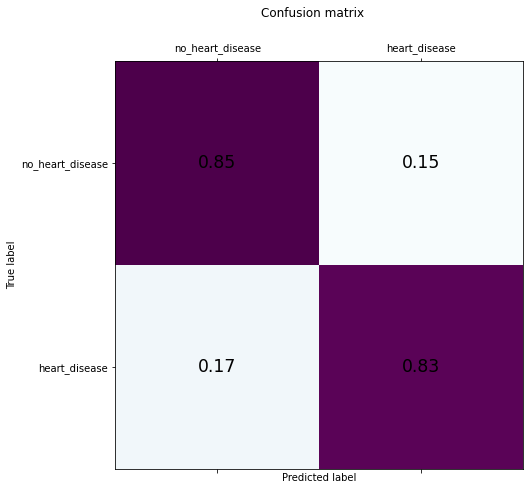

The accuracy is: 83.7%
The true positive rate is: 82.8%


In [8]:
rf_name = 'random_forest'
prediction = random_clf.predict(X_test.astype(np.float32))
rounded_prediction = tf.math.round(prediction)
# create a confusion matrix
conf_matrix = confusion_matrix(y_true=y_test.astype(np.float32), y_pred=rounded_prediction)
tpr = visualize_confusion(conf_matrix, rf_name)

print('The accuracy is: ' +'{:.1%}'.format(random_score))
print('The true positive rate is: ' +'{:.1%}'.format(tpr))

FixedFormatter should only be used together with FixedLocator


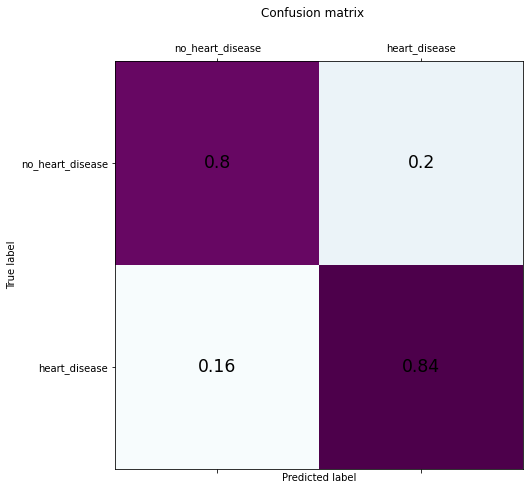

The accuracy is: 82.7%
The true positive rate is: 84.5%


In [9]:
grad_name = 'gradient_boost'
prediction = grad_clf.predict(X_test.astype(np.float32))
rounded_prediction = tf.math.round(prediction)
# create a confusion matrix
conf_matrix = confusion_matrix(y_true=y_test.astype(np.float32), y_pred=rounded_prediction)
tpr = visualize_confusion(conf_matrix, grad_name)

print('The accuracy is: ' +'{:.1%}'.format(grad_score))
print('The true positive rate is: ' +'{:.1%}'.format(tpr))

FixedFormatter should only be used together with FixedLocator


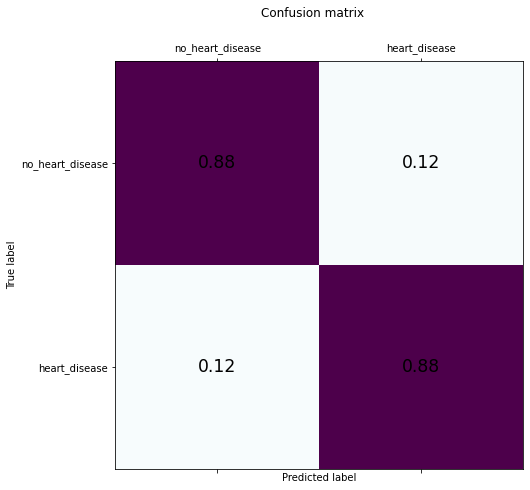

The accuracy is: 87.8%
The true positive rate is: 87.9%


In [10]:
lr_name = 'logistic_regression'
prediction = lr_clf.predict(X_test.astype(np.float32))
rounded_prediction = tf.math.round(prediction)
# create a confusion matrix
conf_matrix = confusion_matrix(y_true=y_test.astype(np.float32), y_pred=rounded_prediction)
tpr = visualize_confusion(conf_matrix, lr_name)

print('The accuracy is: ' +'{:.1%}'.format(lr_score))
print('The true positive rate is: ' +'{:.1%}'.format(tpr))

Next step is to train a neural network. For this a sequential model with 25 input nodes, 13 hidden nodes, 1 dropout layer
and 1 node output layer with sigmoid activation function is created.

__Build the model__

In [11]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(13, activation='relu', input_dim=X_train.shape[1]),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

To achieve good results the Adam optimizer and a binary crossentropy loss function is chosen. For comparison the metrics
'accuracy' and 'recall' are used.

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(name='recall'), 'accuracy'])

To avoid overfitting an EarlyStopping callback is used. The monitoring feature is the loss. The callback will stop
the training if the loss will not decrease within 50 iterations (_patience_). The weights of the best run will be restored
for the final model.

In [13]:
early_stopping_monitor = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

__Train the model__

In [14]:
history = model.fit(X_train.astype(np.float32),
                    y_train.astype(np.float32),
                    callbacks=[early_stopping_monitor],
                    epochs=1000,
                    verbose=2)

Epoch 1/1000
7/7 - 0s - loss: 0.8237 - recall: 0.0392 - accuracy: 0.5000
Epoch 2/1000
7/7 - 0s - loss: 0.7507 - recall: 0.0588 - accuracy: 0.5051
Epoch 3/1000
7/7 - 0s - loss: 0.7178 - recall: 0.0980 - accuracy: 0.5000
Epoch 4/1000
7/7 - 0s - loss: 0.6897 - recall: 0.1471 - accuracy: 0.5354
Epoch 5/1000
7/7 - 0s - loss: 0.6884 - recall: 0.1667 - accuracy: 0.5152
Epoch 6/1000
7/7 - 0s - loss: 0.6671 - recall: 0.2157 - accuracy: 0.5152
Epoch 7/1000
7/7 - 0s - loss: 0.6611 - recall: 0.3235 - accuracy: 0.5808
Epoch 8/1000
7/7 - 0s - loss: 0.6280 - recall: 0.4608 - accuracy: 0.6414
Epoch 9/1000
7/7 - 0s - loss: 0.6151 - recall: 0.4706 - accuracy: 0.6818
Epoch 10/1000
7/7 - 0s - loss: 0.6062 - recall: 0.5686 - accuracy: 0.7020
Epoch 11/1000
7/7 - 0s - loss: 0.5729 - recall: 0.7157 - accuracy: 0.7727
Epoch 12/1000
7/7 - 0s - loss: 0.5652 - recall: 0.6863 - accuracy: 0.7677
Epoch 13/1000
7/7 - 0s - loss: 0.5811 - recall: 0.7059 - accuracy: 0.7626
Epoch 14/1000
7/7 - 0s - loss: 0.5677 - recall:

__Evaluate the model__

4/4 - 0s - loss: 0.3053 - recall: 0.8966 - accuracy: 0.8776


Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


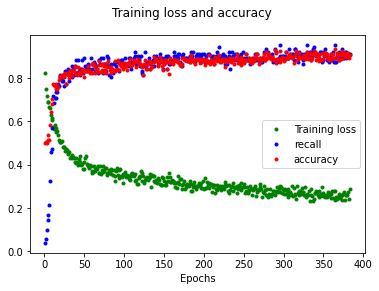

In [15]:
eval_results = model.evaluate(X_test.astype(np.float32), y_test.astype(np.float32), verbose=2)

loss = history.history['loss']
rec = history.history['recall']
acc = history.history['accuracy']

epochs = range(1, len(loss) + 1)

fig_SI = plt.figure()

ax1_SI = fig_SI.add_subplot(111)

ax1_SI.plot(epochs, loss, 'g.', label='Training loss')
ax1_SI.plot(epochs, rec, 'b.', label='recall')
ax1_SI.plot(epochs, acc, 'r.', label='accuracy')

fig_SI.suptitle('Training loss and accuracy')
ax1_SI.set_xlabel('Epochs')
ax1_SI.legend()
fig_SI.show()

FixedFormatter should only be used together with FixedLocator


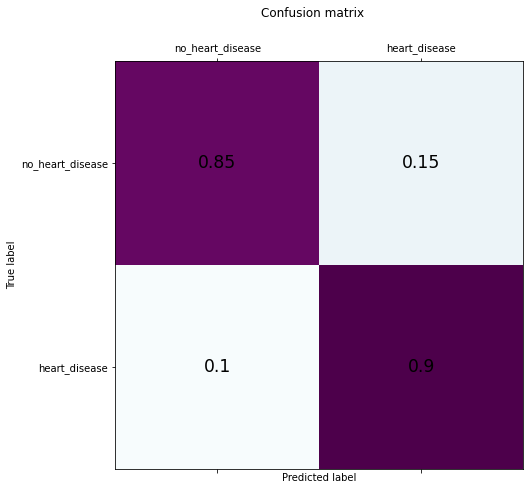

The accuracy is: 87.8%
The true positive rate is: 89.7%


In [16]:
prediction = model.predict(X_test.astype(np.float32))
rounded_prediction = tf.math.round(prediction)
# create a confusion matrix
conf_matrix = confusion_matrix(y_true=y_test.astype(np.float32), y_pred=rounded_prediction)
keras_name = 'neural_net'
tpr = visualize_confusion(conf_matrix,keras_name)

print('The accuracy is: ' +'{:.1%}'.format(eval_results[2]))
print('The true positive rate is: ' +'{:.1%}'.format(tpr))

The recall value is around 90%. That's great and shows the model training was successful.

For later analysis it's interesting to know which datapoints were incorrectly predicted. For this the incorrect
predicted datapoint sets are separated in "not predicted (pred = 0) as heart disease (y_true = 1)"
(_heart__disease__predicion__wrong_) and "predicted (pred = 1) as heart disease (y_true = 0)"
(_no__heart__disease__predicion__wrong_). It is interesting to analyse which features influenced the result in
such a way that it became wrong.

In [36]:
#find indices with wrong predcition
heart_disease_predicion_wrong = [] #y_true = 1; pred = 0
no_heart_disease_predicion_wrong = [] #y_true = 0; pred = 1

heart_disease_X_test = []
no_heart_disease_X_test = []

for i in range(len(X_test)):

    tmp_pred = rounded_prediction[i].numpy()
    prediction_for_test = int(tmp_pred)
    y_test_for_test = y_test.iloc[i]
    if 0 == y_test_for_test:
        if y_test_for_test != prediction_for_test:
            no_heart_disease_predicion_wrong.append(i)
        else:
            no_heart_disease_X_test.append(i)
    elif 1 == y_test_for_test:
        if y_test_for_test != prediction_for_test:
            heart_disease_predicion_wrong.append(i)
        else:
            heart_disease_X_test.append(i)

print(heart_disease_predicion_wrong)
print(no_heart_disease_predicion_wrong)

[6, 10, 23, 75, 88, 89]
[4, 17, 21, 42, 86, 96]


__Visualize the features with biggest impact on the output__

For visualization the [shap](https://github.com/slundberg/shap) package is used.

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


keras is no longer supported, please use tf.keras instead.


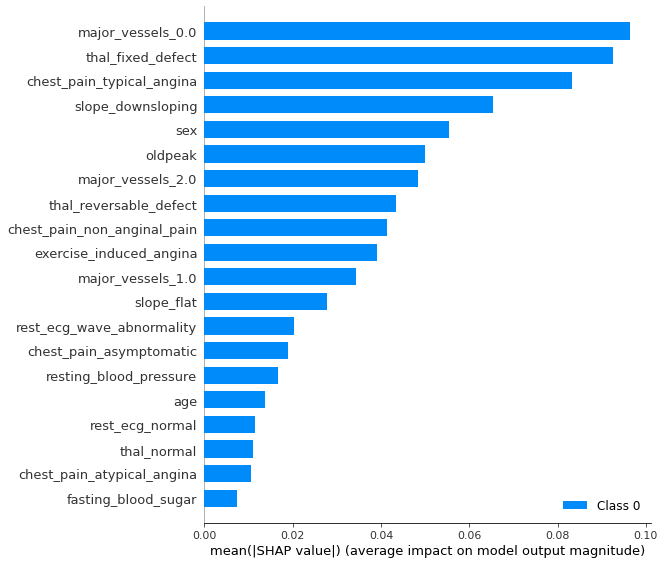

In [33]:
shap.initjs()

col_names = list(X_train)
tmp = X_train.astype(np.float32)
X_train_flatten = tmp.to_numpy()

tmp_2 = X_test.astype(np.float32)
X_test_flatten = tmp_2.to_numpy()

e = shap.DeepExplainer(model, X_train_flatten)
shap_values = e.shap_values(X_test_flatten)
shap.summary_plot(shap_values, X_test_flatten, feature_names=col_names)

This chart shows the average impact of the dataset features on the model output. It's visible that the feature
 _major__vessels__0.0_ has the biggest impact on the model output. The value 0 means that
no major vessels are visible on the flourosopy picture. It's a significant feature of a heart disease. On the other hand
a large number of major vessels like the feature _major__vessels__3.0_ is an indicator of a low heart disease probability.

It's also visible that the feature chest pain (as typical angina and non anginal pain) has an big impact on the output
and also the sex.

The drawback of this kind of visualization is the missing information, if the feature impacts the output positively or
negatively.

#### Heart disease datapoints
To get a feeling which features have a positive or negative impact on the output, a ___force plot___ is used.
The next three plots are datapoint set that are initially labeled as _heart disease_ and were correct predicted.


In [40]:
# get the average model output value
expected_value= tf.keras.backend.get_value(e.expected_value[0])

In [78]:
# save plots in the image folder
current_directory = os.getcwd()
image_folder_tmp = 'images'
image_folder = os.path.join(current_directory,image_folder_tmp)

In [84]:
index = heart_disease_X_test[0]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'heart_disease_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

This datapoint set has a probability of 96% to be a _heart disease_ (true label is also heart disease). This __force plot__
visualizes the features that increase (red arrows) and decrease (blue arrows) the probabilty value. Starting from the
average model output value (base value ~0.52) the features are summed up.

The result seems to be realistic. The presence of zero visible major vessels (_major__vessels__0.0 = 1_) and a fixed defect
thalassaemia (_thal__fixed__defect = 1_) and the absence of normal chest pain (_chest__pain__typical__angina = 0_) is very
significant for a heart disease. As visible in the above chart this three features have the biggest impact on the output.

In [85]:
index = heart_disease_X_test[1]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'heart_disease_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

This datapoint set has a probability of 72% to be a _heart disease_ (true label is also heart disease).

The result also seems to be realistic. The presence of zero visible major vessels (_major__vessels__0.0 = 1_) and of
non anginal chest pain (_chest__pain__non__anginal__pain = 1_)  is very significant for a heart disease. Additionally the
fact that the patient is a woman (_sex = 0_) increases the heart disease probability.

Compared to the previous force plot the probability of 72% is lower than 96%. This is due to an absence of the "high impact"
feature fixed defect thalassaemia (_thal__fixed__defect = 0_) that decreases the output value.

In [86]:
index = heart_disease_X_test[2]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'heart_disease_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

This datapoint set has a probability of 59% to be a _heart disease_ (true label is also heart disease).

The result also seems to be realistic because "high impact" features are in balance and it seems
really not to be clear if it is a heart disease or not. This is reflected in a probability of 59%.
On the one hand the presence of zero visible major vessels (_major__vessels__0.0 = 1_) and an ansymptomatic chest pain
(_chest__pain__asymptomatic = 1_) and on the other hand the absence of a fixed defect thalassaemia
 (_thal__fixed__defect = 0_) but a presence of a reversable defect thalassaemia (_thal__reversable__defect = 1_)
balance each other out.

#### No heart disease datapoints

Now it's interesting to analyze which features are most important for datapoint set that where initially labeled
as _no heart disease_ and were correct predicted.

In [87]:
index = no_heart_disease_X_test[0]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'no_heart_disease_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

This datapoint set has a probability of 21% to be a _heart disease_ (true label is also no heart disease).

The result also seems to be realistic. There is a presence of zero visible major vessels (_major__vessels__0.0 = 1_),
but also a presence of normal thalassaemia (_thal__normal = 1_) and a absence of a fixed thalassaemia defect (_thal__fixed__defect = 0_). Additionally, it is a typical angina chest pain
(_chest__pain__typical__angina = 1_) and the angina was induced by exercise (_exercise__induced__angina = 1_). The
patient seems to have a problem but not a heart disease.

In [88]:
index = no_heart_disease_X_test[1]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'no_heart_disease_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

This datapoint set has a probability of 1% to be a _heart disease_ (true label is also no heart disease).

The result also seems to be realistic and significant. There is a presence of one visible major vessels
(_major__vessels__1.0 = 1_), a reversable thalassaemia defect (_thal__reversable__defect = 1_) and the angina was induced by exercise (_exercise__induced__angina = 1_). The
patient seems to have a problem but not a heart disease.

In [89]:
index = no_heart_disease_X_test[2]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'no_heart_disease_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

This datapoint set has a probability of 0% to be a _heart disease_ (true label is also no heart disease).

The result also seems to be realistic and significant. There is a presence of one visible major vessels
(_major__vessels__1.0 = 1_), a typical angina chest pain (_chest__pain__typical__angina = 1_) and
the angina was induced by exercise (_exercise__induced__angina = 1_). The patient seems to have a problem but not a heart disease.

#### Heart disease datapoints incorrectly predicted as no heart disease

The next three datapoint sets are initially labeled as _heart disease_ but they are predicted
to be _no heart disease_

In [90]:
# predicted to be not a heart disease but true label is 1
index = heart_disease_predicion_wrong[0] #y_true = 1; pred = 0[2]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'heart_disease_prediction_wrong_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

In [91]:
# predicted to be not a heart disease but true label is 1
index = heart_disease_predicion_wrong[1] #y_true = 1; pred = 0[2]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'heart_disease_prediction_wrong_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

In [92]:
# predicted to be not a heart disease but true label is 1
index = heart_disease_predicion_wrong[2] #y_true = 1; pred = 0[2]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'heart_disease_prediction_wrong_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

Checking out the three plots shows the probabilities of 21%, 48% and 16%. On one side the datapoint set with 48% is in the middle
and could be both a _heart disease_ and _no heart disease_ on the other side 21% and 16% are very significant.

An analysis of the three plots shows a presence of zero visible major vessels (_major__vessels__0.0 = 1_). This is the most
significant feature for a heart disease. Additionally, all three patients had a typical angina chest pain
(_chest__pain__typical__angina = 1_) and in two cases the angina was induced by exercise (_exercise__induced__angina = 1_).
Both features were also present in the _no heart disease_ datapoint sets. It is also noticeable that in this "wrong
prediction cases" the feature _oldpeak_ is present.


#### No Heart disease datapoints incorrectly predicted as heart disease

The next step is to analyse datapoint sets that are initially labeled as _no heart disease_ but they are predicted
to be _heart disease_.

In [93]:
# predicted to be a heart disease but true label is 0
index = no_heart_disease_predicion_wrong[0]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'no_heart_disease_prediction_wrong_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

In [94]:
# predicted to be a heart disease but true label is 0
index = no_heart_disease_predicion_wrong[1]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'no_heart_disease_prediction_wrong_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

In [95]:
# predicted to be a heart disease but true label is 0
index = no_heart_disease_predicion_wrong[2]
plot = shap.force_plot(expected_value, shap_values[0][index, :], X_test.iloc[index, :])

filename = 'no_heart_disease_prediction_wrong_' + str(index) + '.htm'
path_to_file = os.path.join(image_folder,filename)
shap.save_html(path_to_file,plot)

plot

Checking out the three plots shows the probabilities of 81%, 56% and 72%. On one side the datapoint set with 56% is in the middle
and could be both a _heart disease_ and _no heart disease_ on the other side 81% and 72% are very significant.

An analysis of the three plots shows a presence of a fixed defect thalassaemia (_thal__fixed__defect = 0_) and
in two of three cases zero visible major vessels (_major__vessels__0.0 = 1_). This are very significant feature for a heart disease.
Additionally, in two cases the chest pain is not a typical angina (_chest__pain__typical__angina = 0_), normally a
typical angina is a significant feature of no heart disease.

### Conclusion

The model has an accuracy of 87.8% and a true positive rate of 89.7%. These values a very good and show that
a heart disease is predictable in 9 of 10 cases. Checking out the feature importance within the neural net
give a good feeling which features are relevant and have a big impact on the model output. Analysing correct
predicted _heart disease_ and _no heart disease_ cases show in which manner the presence or absence of a feature
impact the output. With this knowledge it is explainable why incorrectly predicted datapoint set were interpreted this way.
